In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization")

In [3]:
!pwd

/content/drive/.shortcut-targets-by-id/1EeCMcJgZ7ESCdUOkuglTKvkRujF4dMrv/DS_301_Project_Group_1_Picture_Colorization


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform: PyTorch transforms for transforms and tensor conversion.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform)
        self.color_dataset = ImageFolder(color_dir, transform=transform)
        self.transform = transform

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [5]:


from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size.
    transforms.ToTensor(),  # Convert images to PyTorch tensors.
])

training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_training_set',
    color_dir=r'./dataset/training_set',
    transform=transform
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_validation_set',
    color_dir=r'./dataset/validation_set',
    transform=transform
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)



In [6]:
import torch
from torch import nn

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)
        # Additional upsampling to correct size
        self.final_upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

        self.final_conv = nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1)
        self.final_activation = nn.Tanh()

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        upsampled = self.final_upsample(conv8_3)
        final_out = self.final_conv(upsampled)
        out_tanh = self.final_activation(final_out)
        # Adjust from [-1, 1] to [0, 1] if still needed
        out_adjusted = (out_tanh + 1) / 2
        return out_adjusted

In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
print("Torch version:",torch.__version__)
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)          # Should print the CUDA version used by PyTorch
print(torch.cuda.get_device_name(0))

Torch version: 2.2.1+cu121
True
12.1
NVIDIA L4


In [10]:
def visualize_results(grayscale, colorized, original):
    """
    Visualize grayscale input, colorized output, and the original color image.
    """
    with torch.no_grad():
        # Convert to numpy arrays
        grayscale = grayscale.cpu().numpy().transpose((1, 2, 0))
        colorized = colorized.cpu().numpy().transpose((1, 2, 0))
        original = original.cpu().numpy().transpose((1, 2, 0))

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(grayscale, cmap='gray')
        ax[0].set_title("Grayscale Input")
        ax[0].axis("off")

        ax[1].imshow(colorized)
        ax[1].set_title("Colorized Output")
        ax[1].axis("off")

        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis("off")

        plt.show()

In [11]:
import matplotlib.pyplot as plt

model = ECCVGenerator().cuda()  # Initialize your model

model_path = r'./model/artifact/vgg-16_loss=MSE_batch32_OneCycleLR/model_state_dict.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

ECCVGenerator(
  (model1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=Tru

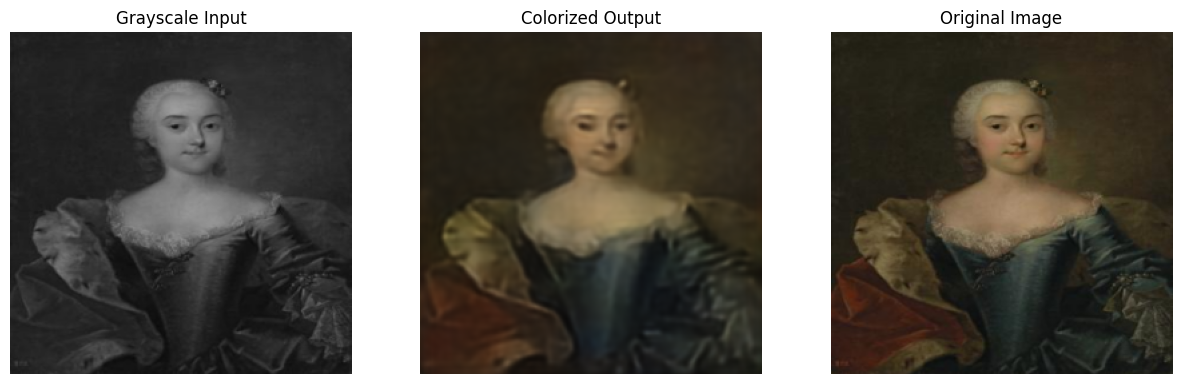

In [12]:
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[5], colorized_outputs[5], original_colors[5])

Evaluations

In [13]:
import torch
import numpy as np
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(image_true, image_test):
    mse = F.mse_loss(image_true, image_test)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

def calculate_mse(image_true, image_test):
    return F.mse_loss(image_true, image_test).item()

def calculate_ssim(image_true, image_test, data_range=1.0, win_size=7):
    # Convert tensors to numpy arrays
    image_true_np = image_true.squeeze().cpu().numpy().transpose((1, 2, 0))
    image_test_np = image_test.squeeze().cpu().numpy().transpose((1, 2, 0))

    # Ensure the window size is odd and smaller than the image dimensions
    win_size = min(win_size, min(image_true_np.shape[:2])-1)
    if win_size % 2 == 0:  # Make the window size odd
        win_size -= 1

    # Calculate SSIM
    ssim_value = ssim(image_true_np, image_test_np, data_range=data_range, multichannel=True, win_size=win_size)
    return ssim_value

In [14]:
def calculate_evaluations(model, validation_loader):
    total_psnr = []
    total_mse = []
    total_ssim = []

    model.eval()
    for grayscale_inputs, original_colors in validation_loader:
        grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

        with torch.no_grad():
            colorized_images = model(grayscale_inputs)

        for colorized, original in zip(colorized_images, original_colors):
            total_psnr.append(calculate_psnr(original.unsqueeze(0), colorized.unsqueeze(0)))
            total_mse.append(calculate_mse(original.unsqueeze(0), colorized.unsqueeze(0)))
            total_ssim.append(calculate_ssim(original.unsqueeze(0), colorized.unsqueeze(0), win_size=3))
    mean_psnr = np.mean(total_psnr)
    mean_mse = np.mean(total_mse)
    mean_ssim = np.mean(total_ssim)
    return mean_psnr, mean_mse, mean_ssim

In [15]:
mean_psnr, mean_mse, mean_ssim = calculate_evaluations(model, validation_loader)
print(f"Mean PSNR: {mean_psnr:.2f}, Mean MSE: {mean_mse:.4f}, Mean SSIM: {mean_ssim:.4f}")

<ipython-input-13-402a1c129d5a>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image_true_np, image_test_np, data_range=data_range, multichannel=True, win_size=win_size)


Mean PSNR: 24.19, Mean MSE: 0.0062, Mean SSIM: 0.7247


AUC

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import cv2

def compute_l2_distance(predicted, ground_truth):
    # Calculate L2 distance in ab color space
    l2_distance = torch.sqrt(torch.sum((predicted - ground_truth) ** 2, dim=1))
    return l2_distance

def compute_proportions(l2_distances, thresholds):
    # Calculate the proportion of pixels below each threshold
    proportions = [(l2_distances < t).float().mean().item() for t in thresholds]
    return proportions


def rgb_to_lab(rgb_images):
    lab_images = []
    for img in rgb_images:
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert from PyTorch tensor to NumPy array
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)  # Convert from RGB to Lab
        lab_images.append(torch.tensor(img_np).permute(2, 0, 1))  # Convert back to PyTorch tensor
    return torch.stack(lab_images)  # Stack all tensor images into a single tensor

# Define your thresholds for L2 distance
thresholds = np.linspace(0, 100, num=100)  # Example thresholds

# Initialize an empty list to store L2 distances for all images
all_l2_distances = []

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = model(grayscale_inputs)


    # Convert colorized and original images from RGB to Lab
    colorized_images_lab = rgb_to_lab(colorized_images)
    original_colors_lab = rgb_to_lab(original_colors)

    # extract the 'a' and 'b' channels
    predicted_ab = colorized_images_lab[:, 1:, :, :]
    ground_truth_ab = original_colors_lab[:, 1:, :, :]


    l2_distances = compute_l2_distance(predicted_ab, ground_truth_ab)
    all_l2_distances.append(l2_distances)

# Concatenate all L2 distances
all_l2_distances = torch.cat(all_l2_distances, dim=0)

# Compute proportions for each threshold
proportions = compute_proportions(all_l2_distances, thresholds)

# Compute the Area under Curve (AuC) for plotting
auc_value = auc(thresholds, proportions)
print(f"AuC: {auc_value:.4f}")

AuC: 89.2675


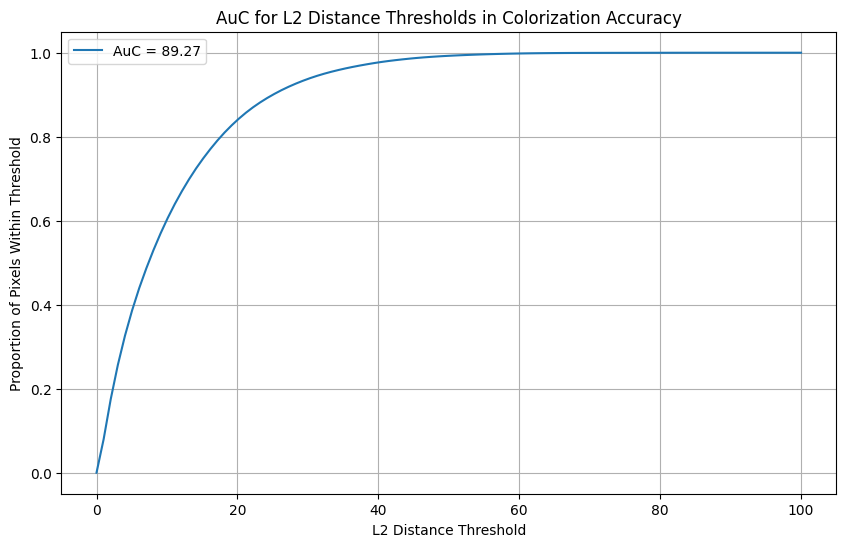

In [17]:
# Plotting the AuC curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, proportions, label=f'AuC = {auc_value:.2f}')
plt.title('AuC for L2 Distance Thresholds in Colorization Accuracy')
plt.xlabel('L2 Distance Threshold')
plt.ylabel('Proportion of Pixels Within Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import torchvision.models as models
import torchvision.transforms as transforms

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True).cuda()
vgg.eval()

# Define a transform to prepare the images for VGG
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 images
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for VGG
])

correct = 0
total = 0
colorized_preds_all = []
original_preds_all = []

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = model(grayscale_inputs)

    # Apply the necessary transforms
    colorized_images_vgg = transform(colorized_images)
    original_colors_vgg = transform(original_colors)

    # Get predictions from VGG
    colorized_preds = vgg(colorized_images_vgg).argmax(dim=1)
    original_preds = vgg(original_colors_vgg).argmax(dim=1)

    # Compare predictions
    colorized_preds_all += colorized_preds
    original_preds_all += original_preds
    correct += (colorized_preds == original_preds).sum().item()
    total += original_colors.size(0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 190MB/s]


In [19]:
# Calculate the accuracy
accuracy = correct / total
print(f"Semantic Interpretability Accuracy: {accuracy:.4f}, where correct = {correct} and total = {total}")

Semantic Interpretability Accuracy: 0.2757, where correct = 236 and total = 856
